In [1]:
# todo 
# clean post correction
# clean the line segmentation
    

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import json
from IPython.display import display, HTML
import difflib
from termcolor import colored
import unicodedata
import pandas as pd
%matplotlib inline

In [48]:
# Define the file path
experiment_number = "bugfix_big_4x"
threshold = 0.20
gcer = False #TODO recheck for bugs
#experiment_number = 2

Big:
Experiment 1: Train 80%, Val 10%, Test 10%  -- for 3 cross validation folds\
Experiment 3: Train 40%, Val 40%, Test 20%  -- for 3 cross validation folds\
Experiment 5: 4x data repeated - Synthetic Data Train 80%, Val 10%, Test 10%  -- for 3 cross validation folds

In [49]:
fold_1_path = f'/home/ocr_proj/OCR/post_correction/pe-ocr-sanskrit/outputs/experiment_{experiment_number}/test_fold_1/'
fold_2_path = f'/home/ocr_proj/OCR/post_correction/pe-ocr-sanskrit/outputs/experiment_{experiment_number}/test_fold_2/'
fold_3_path = f'/home/ocr_proj/OCR/post_correction/pe-ocr-sanskrit/outputs/experiment_{experiment_number}/test_fold_3/'

## Helper Fuctions

In [50]:


def format_json(data):
    # Recursive function to format JSON data
    def format_item(item):
        if isinstance(item, dict):
            formatted = "<ul>"
            for key, value in item.items():
                formatted += f"<li><strong>{key}:</strong> {format_item(value)}</li>"
                formatted += f"<br>"
            formatted += "</ul>"
            return formatted
        elif isinstance(item, list):
            formatted = "<ul>"
            for sub_item in item:
                formatted += f"<li>{format_item(sub_item)}</li>"
                formatted += f"<br>"
            formatted += "</ul>"
            return formatted
        else:
            return f"<span>{item}</span>"
    
    return format_item(data)

def display_side_by_side(json_data1, json_data2, title1="JSON File 1", title2="JSON File 2"):
    formatted_json1 = format_json(json_data1)
    formatted_json2 = format_json(json_data2)
    
    # Create HTML for side-by-side display
    html = f"""
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 45%; padding: 10px; border: 1px solid #ddd; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
            <h3>{title1}</h3>
            {formatted_json1}
        </div>
        <div style="width: 45%; padding: 10px; border: 1px solid #ddd; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
            <h3>{title2}</h3>
            {formatted_json2}
        </div>
    </div>
    """
    
    display(HTML(html))

In [51]:


def highlight_changes(line1, line2, post_corrected=False):
    # Generate a diff between the two lines
    diff = list(difflib.ndiff(line1, line2))

    # Create colored output based on diff
    highlighted_line1 = []
    highlighted_line2 = []

    i = 0
    while i < len(diff):
        if diff[i].startswith('- ') and i+1 < len(diff) and diff[i+1].startswith('+ '):
            # Replace operation
            highlighted_line1.append(colored(diff[i][2:], 'yellow', attrs=['bold']))
            highlighted_line2.append(colored(diff[i+1][2:], 'yellow', attrs=['bold']))
            i += 2
        elif diff[i].startswith('- '):
            # Delete operation
            highlighted_line1.append(colored(diff[i][2:], 'blue', attrs=['bold']))
            highlighted_line2.append(colored(' ', 'blue', attrs=['bold']))
            i += 1
        elif diff[i].startswith('+ '):
            # Insert operation
            highlighted_line1.append(colored(' ', 'red', attrs=['bold']))
            highlighted_line2.append(colored(diff[i][2:], 'red', attrs=['bold']))
            i += 1
        elif diff[i].startswith('  '):
            # Unchanged characters
            highlighted_line1.append(diff[i][2:])
            highlighted_line2.append(diff[i][2:])
            i += 1
        else:
            # Skip '?' lines
            i += 1

    final_line1 = ''.join(highlighted_line1)
    final_line2 = ''.join(highlighted_line2)

    # Ensure equal length by padding with spaces
    max_length = max(len(final_line1), len(final_line2))
    final_line1 = final_line1.ljust(max_length)
    final_line2 = final_line2.ljust(max_length)

    if post_corrected:
        print("Ground Truth  : " + final_line2)
        print("Post Corrected: " + final_line1)
    else:
        print("OCR Output    : " + final_line1)
        print("Ground Truth  : " + final_line2)

# Example usage:
highlight_changes("abcdef", "abxcef")



### GRAPHEME CLUSTER ERROR RATE FUNCTIONS BELOW
def list_correct_grapheme_clusters(devanagari_string):
    combining_marks = {'्', 'ँ', 'ं', 'ः', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॢ', 'ॣ', 'े', 'ै', 'ो', 'ौ', '़','ॅ'}
    graphemes = []
    temp_grapheme = ""
    for char in devanagari_string:
        if unicodedata.combining(char) == 0 and char not in combining_marks:
            # If temp_grapheme has something and last char was not virama, append to graphemes
            if temp_grapheme and not temp_grapheme.endswith('्'):
                graphemes.append(temp_grapheme)
                temp_grapheme = char
            else:
                temp_grapheme += char
        else:
            temp_grapheme += char  # Add combining mark or virama to current grapheme

    # Append the last grapheme if exists
    if temp_grapheme:
        graphemes.append(temp_grapheme)

    return graphemes


def non_matching_graphemes(s, s1):

    # Split both strings into graphemes
    graphemes_s = list_correct_grapheme_clusters(s)
    graphemes_s1 = list_correct_grapheme_clusters(s1)

    # Find the LCS to align graphemes instead of characters
    m, n = len(graphemes_s), len(graphemes_s1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if graphemes_s[i - 1] == graphemes_s1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Reconstruct the sequence of non-matching graphemes
    non_matching = []
    error_count = 0
    while m > 0 and n > 0:
      # if the grapheme clusters match
        if graphemes_s[m - 1] == graphemes_s1[n - 1]:
            m, n = m - 1, n - 1

      # if they dont match
        else:
            temp_s, temp_s1 = "", ""

            while m > 0 and (n == 0 or dp[m][n] == dp[m-1][n]):
                temp_s = graphemes_s[m - 1] + temp_s
                m -= 1

            while n > 0 and (m == 0 or dp[m][n] == dp[m][n-1]):
                temp_s1 = graphemes_s1[n - 1] + temp_s1
                n -= 1

            # if(len(temp_s)>3):
              # print(list_correct_grapheme_clusters(temp_s))
            if(len(list_correct_grapheme_clusters(temp_s))>=len(list_correct_grapheme_clusters(temp_s1))):

              temp_list = list_correct_grapheme_clusters(temp_s)

            else:
              temp_list = list_correct_grapheme_clusters(temp_s1)

            temp_list.reverse()
            error_count += len(temp_list)
            non_matching.extend(temp_list)

    # print(m,n)
    non_matching.reverse()
    # print(non_matching)
    # print(graphemes_s)
    return(error_count/len(graphemes_s))

def calculate_gcer(pg_annot,pg_pred):
  errors = non_matching_graphemes(pg_annot, pg_pred)
  return errors

OCR Output    : ab cdef
Ground Truth  : abxc ef


In [ ]:


def highlight_changes(line1, line2, post_corrected=False):
    # Generate a diff between the two lines
    diff = list(difflib.ndiff(line1, line2))

    # Create colored output based on diff
    highlighted_line1 = []
    highlighted_line2 = []

    i = 0
    while i < len(diff):
        if diff[i].startswith('- ') and i+1 < len(diff) and diff[i+1].startswith('+ '):
            # Replace operation
            highlighted_line1.append(colored(diff[i][2:], 'yellow', attrs=['bold']))
            highlighted_line2.append(colored(diff[i+1][2:], 'yellow', attrs=['bold']))
            i += 2
        elif diff[i].startswith('- '):
            # Delete operation
            highlighted_line1.append(colored(diff[i][2:], 'blue', attrs=['bold']))
            highlighted_line2.append(colored(' ', 'blue', attrs=['bold']))
            i += 1
        elif diff[i].startswith('+ '):
            # Insert operation
            highlighted_line1.append(colored(' ', 'red', attrs=['bold']))
            highlighted_line2.append(colored(diff[i][2:], 'red', attrs=['bold']))
            i += 1
        elif diff[i].startswith('  '):
            # Unchanged characters
            highlighted_line1.append(diff[i][2:])
            highlighted_line2.append(diff[i][2:])
            i += 1
        else:
            # Skip '?' lines
            i += 1

    final_line1 = ''.join(highlighted_line1)
    final_line2 = ''.join(highlighted_line2)

    # Ensure equal length by padding with spaces
    max_length = max(len(final_line1), len(final_line2))
    final_line1 = final_line1.ljust(max_length)
    final_line2 = final_line2.ljust(max_length)

    if post_corrected:
        print("Ground Truth  : " + final_line2)
        print("Post Corrected: " + final_line1)
    else:
        print("OCR Output    : " + final_line1)
        print("Ground Truth  : " + final_line2)

# Example usage:
highlight_changes("abcdef", "abxcef")



### GRAPHEME CLUSTER ERROR RATE FUNCTIONS BELOW
def list_correct_grapheme_clusters(devanagari_string):
    combining_marks = {'्', 'ँ', 'ं', 'ः', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॢ', 'ॣ', 'े', 'ै', 'ो', 'ौ', '़','ॅ'}
    graphemes = []
    temp_grapheme = ""
    for char in devanagari_string:
        if unicodedata.combining(char) == 0 and char not in combining_marks:
            # If temp_grapheme has something and last char was not virama, append to graphemes
            if temp_grapheme and not temp_grapheme.endswith('्'):
                graphemes.append(temp_grapheme)
                temp_grapheme = char
            else:
                temp_grapheme += char
        else:
            temp_grapheme += char  # Add combining mark or virama to current grapheme

    # Append the last grapheme if exists
    if temp_grapheme:
        graphemes.append(temp_grapheme)

    return graphemes


def non_matching_graphemes(s, s1):

    # Split both strings into graphemes
    graphemes_s = list_correct_grapheme_clusters(s)
    graphemes_s1 = list_correct_grapheme_clusters(s1)

    # Find the LCS to align graphemes instead of characters
    m, n = len(graphemes_s), len(graphemes_s1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if graphemes_s[i - 1] == graphemes_s1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Reconstruct the sequence of non-matching graphemes
    non_matching = []
    error_count = 0
    while m > 0 and n > 0:
      # if the grapheme clusters match
        if graphemes_s[m - 1] == graphemes_s1[n - 1]:
            m, n = m - 1, n - 1

      # if they dont match
        else:
            temp_s, temp_s1 = "", ""

            while m > 0 and (n == 0 or dp[m][n] == dp[m-1][n]):
                temp_s = graphemes_s[m - 1] + temp_s
                m -= 1

            while n > 0 and (m == 0 or dp[m][n] == dp[m][n-1]):
                temp_s1 = graphemes_s1[n - 1] + temp_s1
                n -= 1

            # if(len(temp_s)>3):
              # print(list_correct_grapheme_clusters(temp_s))
            if(len(list_correct_grapheme_clusters(temp_s))>=len(list_correct_grapheme_clusters(temp_s1))):

              temp_list = list_correct_grapheme_clusters(temp_s)

            else:
              temp_list = list_correct_grapheme_clusters(temp_s1)

            temp_list.reverse()
            error_count += len(temp_list)
            non_matching.extend(temp_list)

    # print(m,n)
    non_matching.reverse()
    # print(non_matching)
    # print(graphemes_s)
    return(error_count/len(graphemes_s))

def calculate_gcer(pg_annot,pg_pred):
  errors = non_matching_graphemes(pg_annot, pg_pred)
  return errors

OCR Output    : ab cdef
Ground Truth  : abxc ef


In [52]:
#csv_file_path = folder_path+'analysis.csv'

csv_file_path_1 = fold_1_path +'analysis.csv'
csv_file_path_2 = fold_2_path +'analysis.csv'
csv_file_path_3 = fold_3_path +'analysis.csv'
df_1 = pd.read_csv(csv_file_path_1, delimiter=';', encoding='utf-8')
df_2 = pd.read_csv(csv_file_path_2, delimiter=';', encoding='utf-8')
df_3 = pd.read_csv(csv_file_path_3, delimiter=';', encoding='utf-8')


# Load the CSV file
#df = pd.read_csv(csv_file_path, delimiter=';', encoding='utf-8')
df = pd.concat([df_1, df_2, df_3], axis=0, ignore_index=True)

In [53]:
df['predicted_text'] = df['predicted_text'].fillna("     ")
# Create 'pre_gcer' column
df['pre_gcer'] = df.apply(lambda row: calculate_gcer(row['target_text'], row['input_text']), axis=1)

# Create 'post_gcer' column
df['post_gcer'] = df.apply(lambda row: calculate_gcer(row['target_text'], row['predicted_text']), axis=1)

# Create 'difference_gcer' column
df['difference_gcer'] = df['post_gcer'] - df['pre_gcer']

In [54]:
def analyse_line(df,id,gcer=gcer):
    if gcer:
        print("GCER Before Post Correction:"+str(df['pre_gcer'].iloc[id]*100)+" %")
        print("GCER After Post Correction :"+str(df['post_gcer'].iloc[id]*100)+" %")
        print("\n")
    else:
        print("CER Before Post Correction:"+str(df['pre_cer'].iloc[id]*100)+" %")
        print("CER After Post Correction :"+str(df['post_cer'].iloc[id]*100)+" %")
        print("\n")

    first_image_path = df['path'].iloc[id]    
    # Load and display the image using matplotlib
    img = mpimg.imread(first_image_path)

    # Print legend
    print(colored("Blue    ", "blue") + ": Extra")
    print(colored("Red     ", "red") + ": Missing")
    print(colored("Yellow  ", "yellow") + ": Replaced")
    print("No color: Unchanged")


    plt.figure(figsize=(30, 30))
    plt.axis('off')
    plt.imshow(img, cmap='gray')


    highlight_changes(df['input_text'].iloc[id], df['target_text'].iloc[id])
    print('')
    highlight_changes(df['predicted_text'].iloc[id], df['target_text'].iloc[id],post_corrected=True)


    

## Report

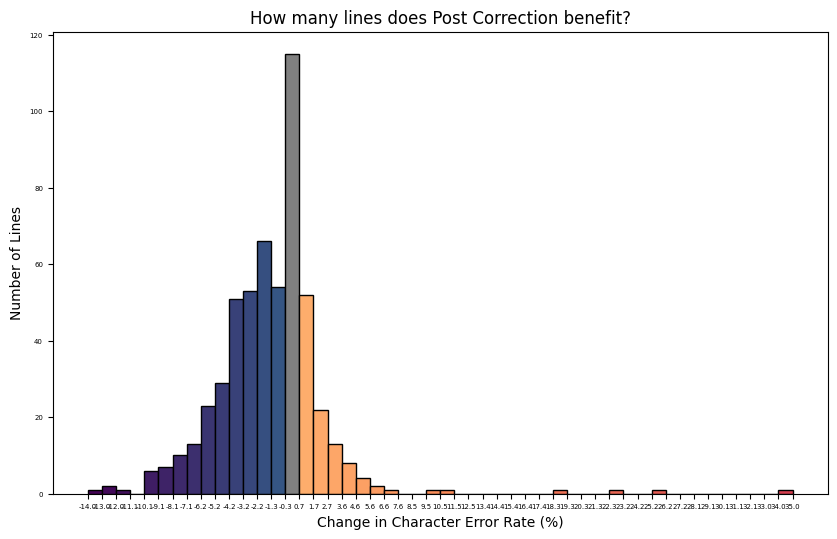

In [55]:
# Plot histogram and get bin edges and counts
plt.figure(figsize=(10, 6))
if gcer:
    counts, bin_edges, patches = plt.hist(df['difference_gcer']*100, bins=50, edgecolor='black')
else:
    counts, bin_edges, patches = plt.hist(df['difference']*100, bins=50, edgecolor='black')

# Normalize bin edges for color mapping
norm = plt.Normalize(bin_edges.min(), bin_edges.max())

# Create custom colormaps that are more color-blind friendly
colors_neg = ['#440154', '#31688e', '#35b779', '#fde725']  # Viridis-like
colors_pos = ['#fee08b', '#fc8d59', '#d53e4f']  # YlOrRd-like

cmap_neg = mcolors.LinearSegmentedColormap.from_list("custom_neg", colors_neg)
cmap_pos = mcolors.LinearSegmentedColormap.from_list("custom_pos", colors_pos)

# Apply colors to bars
for i, patch in enumerate(patches):
    # Determine bin edges
    left_edge = bin_edges[i]
    right_edge = bin_edges[i + 1]
    
    # Check if bin includes zero
    if left_edge <= 0 <= right_edge:
        # Set the color of the bin that includes zero to gray
        color = 'gray'
    elif right_edge < 0:
        # Color for bins with negative values
        bin_center = (left_edge + right_edge) / 2
        color = cmap_neg(norm(bin_center))
    else:
        # Color for bins with positive values
        bin_center = (left_edge + right_edge) / 2
        color = cmap_pos(norm(bin_center))
    
    patch.set_facecolor(color)


plt.xticks(ticks=bin_edges, fontsize=5)
plt.yticks(fontsize=5)  # Decrease the font size of x-axis ticks
# Format x-axis tick labels to one decimal place
formatter = FuncFormatter(lambda x, _: f'{x:.1f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('How many lines does Post Correction benefit?')
if gcer:
    plt.xlabel('Change in Grapheme Cluster Error Rate (%)')
else:
    plt.xlabel('Change in Character Error Rate (%)')
plt.ylabel('Number of Lines')

# Show the plot
plt.show()

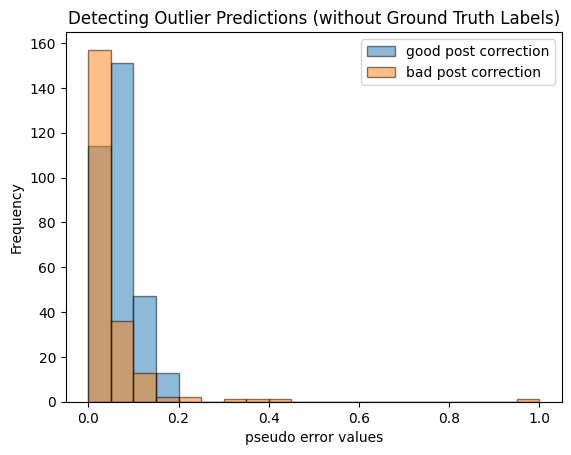

Abnormally Bad Line at : 169
Abnormally Bad Line at : 177
Abnormally Bad Line at : 178
Abnormally Bad Line at : 179
Abnormally Bad Line at : 359
Abnormally Bad Line at : 538


In [56]:
import editdistance as ed

def calculate_cer(predicted_text, transcript,gcer=False):
    if gcer:
        cer = calculate_gcer(transcript,predicted_text)
    else:
        cer = ed.eval(predicted_text, transcript) / max(len(predicted_text), len(transcript))
    return cer

good_pseudo = []
bad_pseudo = []
bad_pseudo_indices = []
good_pseudo_indices = []

ocr_errors = []
post_correction_errors = []

nan_predicted_indices = []

for index, row in df.iterrows():

    input_text = str(row['input_text'])
    predicted_text = row['predicted_text']
    target_text = str(row['target_text'])

    ocr_error = calculate_cer(input_text, target_text,gcer=gcer) #we need ground truth for this
    #try:
    post_correction_error = calculate_cer(predicted_text, target_text,gcer=gcer) # we need ground truth for this too
    pseudo_error = calculate_cer(input_text, predicted_text,gcer=gcer) # this is ALWAYS availabe!
    # except:
    #     print(type(predicted_text))
    #     predicted_text = str(predicted_text)
    #     post_correction_error = calculate_cer(predicted_text, target_text,gcer=gcer) # we need ground truth for this too
    #     pseudo_error = calculate_cer(input_text, predicted_text,gcer=gcer) # this is ALWAYS availabe!
    #     nan_predicted_indices.append(index)
        
    

    # can we use pseudo error to guess when the (post_correction_error - ocr_error) would be positive(bad)
    if post_correction_error-ocr_error <0: #GOOD
        good_pseudo.append(pseudo_error)
        good_pseudo_indices.append(index)
    else: #BAD
        bad_pseudo.append(pseudo_error)
        bad_pseudo_indices.append(index)

    post_correction_errors.append(post_correction_error)
    ocr_errors.append(ocr_error)

num_bins = 20
# Create the histogram plot
# Determine the overall range of the data
min_val = min(np.min(good_pseudo), np.min(bad_pseudo))
max_val = max(np.max(good_pseudo), np.max(bad_pseudo))

# Create an array of bin edges
bins = np.linspace(min_val, max_val, 21)  # 21 edges to create 20 bins

# Plot the histograms
plt.hist(good_pseudo, bins=bins, alpha=0.5, label='good post correction', edgecolor='black')
plt.hist(bad_pseudo, bins=bins, alpha=0.5, label='bad post correction', edgecolor='black')



# Add labels and title
plt.xlabel('pseudo error values')
plt.ylabel('Frequency')
plt.title('Detecting Outlier Predictions (without Ground Truth Labels)')
plt.legend(loc='upper right')

# Show the plot
plt.show()


abnormal_lines_indices = []
for val,i in zip(bad_pseudo,bad_pseudo_indices):
    if val>threshold:
        print(f'Abnormally Bad Line at : {i}')
        abnormal_lines_indices.append(i)

for val,i in zip(good_pseudo,good_pseudo_indices):
    if val>threshold:
        print(f'Abnormally Good Line at : {i}')
        abnormal_lines_indices.append(i)

abnormal_lines_indices = abnormal_lines_indices+nan_predicted_indices

In machine learning it is common to split the data we have into training data, validation data and test data. The validation data helps us fine tune the hyperparameters, and the test data helps us gauge how our model will perform when deployed.\
Both, Validataion Data and Test Data are proxys for what we would observe after deployment. But unlike the Validation and Test splits, the data we observe after deployment does not have ground truth labels.\
Similarly, we have ground truth labels for our validation and test datasets. We observe that sometimes the model hallucinates really bad for some lines which brings down the CER for the entire page/manuscript. We would like to catch these lines, even in the absense of ground truth data - which would be the case when the model is deployed.\
We observe that: **If a post corrected Line A's CER compared with the ground truth is bad, then the post corrected Line A's CER when compared with the OCR output would also be bad.** We can use this observation to catch abnormal lines without the need to have ground truth labels.

In [57]:
def remove_elements(original_list, indices_to_remove):
    return [elem for i, elem in enumerate(original_list) if i not in indices_to_remove]

In [58]:
def keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,indices_to_remove):
    return_this = []
    for index, (item1, item2) in enumerate(zip(post_correction_errors, ocr_errors)):
        if index not in indices_to_remove:
            return_this.append(item1)
        else:
            return_this.append(item2)
    return return_this


In [59]:
if gcer:
    print(f'The average GCER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average GCER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the GCER becomes {np.mean(keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,abnormal_lines_indices))}')
else:
    print(f'The average CER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average CER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the CER becomes {np.mean(keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,abnormal_lines_indices))}')

#print(f'The average CER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average CER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the CER becomes')

The average CER of the OCRed Text is 0.08042779303952728.
The average CER of the Post-Corrected Text is 0.06452234652573596.
After Removing Abnormal Lines the CER becomes 0.06240403389168722


The average CER of the OCRed Text is 0.0804277930395273.\
The average CER of the Post-Corrected Text is 0.07152090412441257.\
After Removing Abnormal Lines the CER becomes 0.06916048145464761



In [60]:
#for experiment 5: 1,3

# Abnormal Line at : 179
# Abnormal Line at : 359
# Abnormal Line at : 491
# Abnormal Line at : 515

CER Before Post Correction:14.000000000000002 %
CER After Post Correction :2.0 %


Blue    : Extra
Red     : Missing
Yellow  : Replaced
No color: Unchanged
OCR Output    : tṛṃtīyetisūtrasyahegutvaviśiṣṭārthavodhakātparātipadikola   tīyāviś  kti bhavatītyartha .yadyapiṃvibhaktivaṃdavi
Ground Truth  : tṛ tīyetisūtrasyahetutvaviśiṣṭārthabodhakātp rātipadik  āttṛtīyāvibhaktirbhavatītyarthaḥ.yadyapi vibhaktivṛṃdavi

Ground Truth  : tṛtīyetisūtrasyahetutvaviśiṣṭārthabodhakātprātipadikāttṛtīyāvibhaktirbhavatītyarthaḥ.yadyapivibhaktivṛṃdavi
Post Corrected: tṛtīyetisūtrasyahetutvaviśiṣṭārthabodhakātprātipadikāttṛtīyāvibhaktirbhavatītyarthaḥ.yadyapivibhaktiva davi


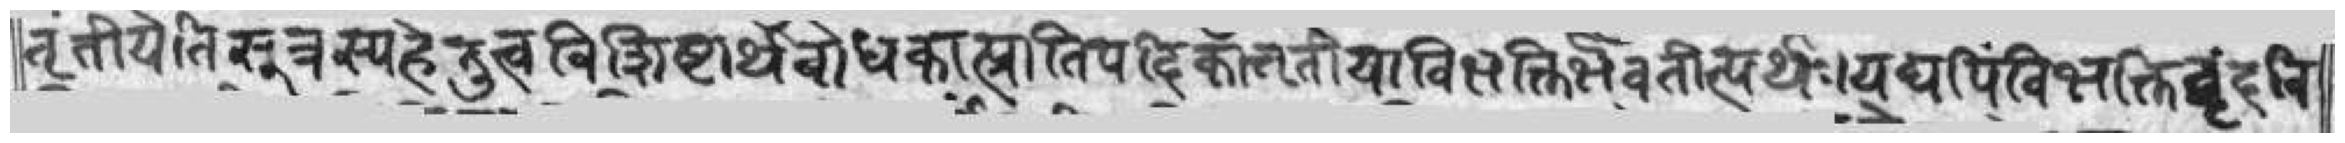

In [62]:
analyse_line(df,2)
#mark missing character as red too..

In [17]:
error_counts_train_paths = [
    fold_1_path + 'error_counts_train.json',
    fold_2_path + 'error_counts_train.json',
    fold_3_path + 'error_counts_train.json'
]
error_counts_test_paths = [
    fold_1_path + 'error_counts_test.json',
    fold_2_path + 'error_counts_test.json',
    fold_3_path + 'error_counts_test.json'
]


In [18]:
# Initialize an empty dictionary to store the combined data
data_train = {}

# Load and combine the JSON files
for path in error_counts_train_paths:
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Merge the loaded data into the combined_data dictionary
        data_train.update(data)

data_test = {}

# Load and combine the JSON files
for path in error_counts_test_paths:
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Merge the loaded data into the combined_data dictionary
        data_test.update(data)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ocr_proj/OCR/post_correction/pe-ocr-sanskrit/outputs/experiment_big_4x/test_fold_1/error_counts_test.json'

In [26]:

display_side_by_side(data_train, data_test, title1="Changes made when transforming the OCR OUTPUT to GROUND TRUTH", title2="Changes made when transforming the OCR OUTPUT using POST CORRECTION")
